C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 0.7390, Training Accuracy: 0.6164, Validation Accuracy: 0.5000
Epoch 2/10, Training Loss: 0.5176, Training Accuracy: 0.8219, Validation Accuracy: 0.5000
Epoch 3/10, Training Loss: 0.3722, Training Accuracy: 0.8630, Validation Accuracy: 0.5000
Epoch 4/10, Training Loss: 0.5922, Training Accuracy: 0.7123, Validation Accuracy: 0.5000
Epoch 5/10, Training Loss: 0.1841, Training Accuracy: 0.9589, Validation Accuracy: 0.5000
Epoch 6/10, Training Loss: 0.0327, Training Accuracy: 0.9863, Validation Accuracy: 0.0000
Epoch 7/10, Training Loss: 0.0425, Training Accuracy: 1.0000, Validation Accuracy: 0.5000
Epoch 8/10, Training Loss: 0.0166, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 9/10, Training Loss: 0.0418, Training Accuracy: 0.9863, Validation Accuracy: 0.5000
Epoch 10/10, Training Loss: 0.0140, Training Accuracy: 1.0000, Validation Accuracy: 0.5000


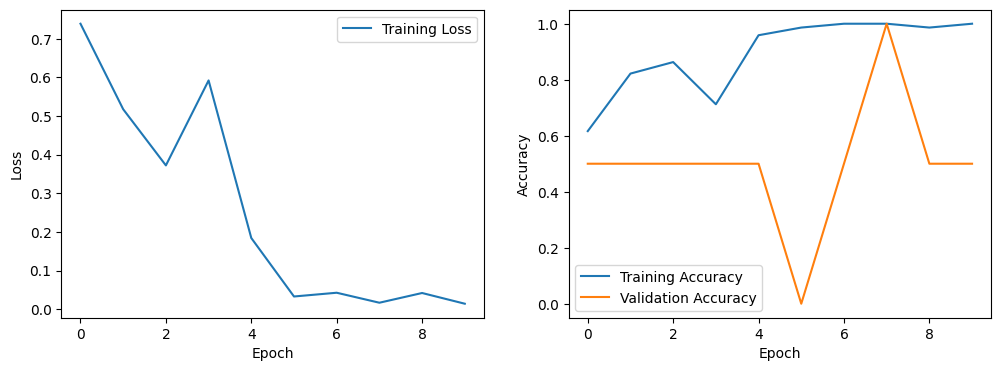

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.5000
[[0 1]
 [0 1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import shutil

def train_and_evaluate(data_path1, data_path2, validation_files, transform=None, num_epochs=10):
    # Image dimensions
    height, width = 224, 224

    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((height, width)),
            transforms.ToTensor(),
        ])

    # Create datasets and loaders
    train_dataset = ImageFolder(root=data_path1, transform=transform)
    test_dataset = ImageFolder(root=data_path2, transform=transform)

    # Extend train dataset with data from the second path
    train_dataset.samples += test_dataset.samples
    train_dataset.targets += test_dataset.targets

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        val_accuracy = validate_model(model, validation_files, transform)
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true, y_pred = validate_model(model, validation_files, transform, return_predictions=True)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

def validate_model(model, validation_files, transform, batch_size=32, return_predictions=False):
    # Create a temporary root directory for ImageFolder
    temp_root = 'temp_validation_folder'
    os.makedirs(temp_root, exist_ok=True)

    # Create a temporary class folder inside the root
    for i, file in enumerate(validation_files):
        class_folder = os.path.join(temp_root, f'class_{i}')
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(file, class_folder)

    # Create the validation dataset using the temporary root
    validation_dataset = ImageFolder(root=temp_root, transform=transform)

    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Remove the temporary root directory
    shutil.rmtree(temp_root)

    if return_predictions:
        return y_true, y_pred
    else:
        val_accuracy = np.sum(y_true == y_pred) / len(y_true)
        return val_accuracy


# Example usage
data_path1 = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram\Read text"
data_path2 = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram\Spontaneous dialogue"
validation_files = [
    r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram\Spontaneous dialogue\PD\ID29_pd_3_1_2_spectrogram.png",
    r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram\Read text\PD\ID24_pd_2_0_0_spectrogram.png"
]  # Add your spectrogram file paths

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_and_evaluate(data_path1, data_path2, validation_files, transform=transform)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 0.3971, Training Accuracy: 0.7241, Validation Accuracy: 0.4667
Epoch 2/10, Training Loss: 0.1200, Training Accuracy: 0.9483, Validation Accuracy: 0.4667
Epoch 3/10, Training Loss: 0.0762, Training Accuracy: 0.9483, Validation Accuracy: 0.4667
Epoch 4/10, Training Loss: 0.0252, Training Accuracy: 0.9828, Validation Accuracy: 0.6667
Epoch 5/10, Training Loss: 0.0017, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 6/10, Training Loss: 0.0149, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 7/10, Training Loss: 0.1399, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 8/10, Training Loss: 0.0072, Training Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 9/10, Training Loss: 0.0223, Training Accuracy: 0.9828, Validation Accuracy: 0.8667
Epoch 10/10, Training Loss: 0.0008, Training Accuracy: 1.0000, Validation Accuracy: 0.8667


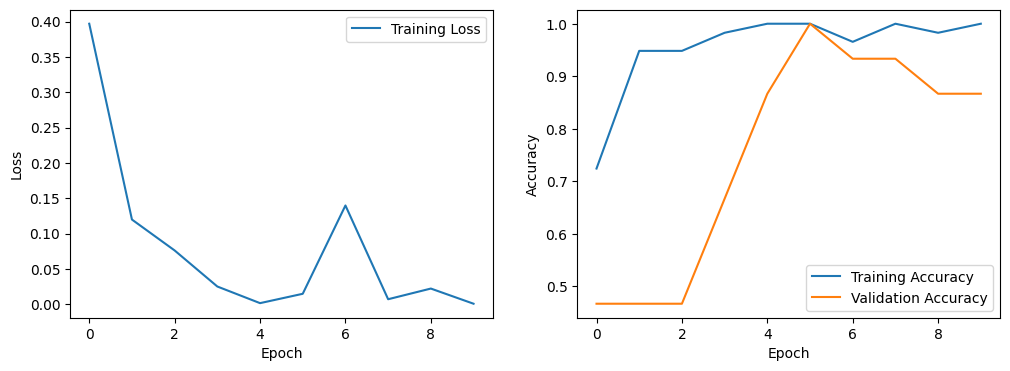

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8667
[[7 1]
 [1 6]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.86      0.86      0.86         7

    accuracy                           0.87        15
   macro avg       0.87      0.87      0.87        15
weighted avg       0.87      0.87      0.87        15



In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=10):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Training Loss: 0.4132, Training Accuracy: 0.7586, Validation Accuracy: 1.0000
Epoch 2/50, Training Loss: 0.5454, Training Accuracy: 0.7759, Validation Accuracy: 0.9333
Epoch 3/50, Training Loss: 0.1615, Training Accuracy: 0.9310, Validation Accuracy: 0.6667
Epoch 4/50, Training Loss: 0.1314, Training Accuracy: 0.9310, Validation Accuracy: 0.7333
Epoch 5/50, Training Loss: 0.0257, Training Accuracy: 0.9828, Validation Accuracy: 0.7333
Epoch 6/50, Training Loss: 0.0493, Training Accuracy: 0.9483, Validation Accuracy: 0.8667
Epoch 7/50, Training Loss: 0.0067, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 8/50, Training Loss: 0.0092, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 9/50, Training Loss: 0.0012, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 10/50, Training Loss: 0.0014, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 11/50, Training Loss: 0.0011, Training Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch 12

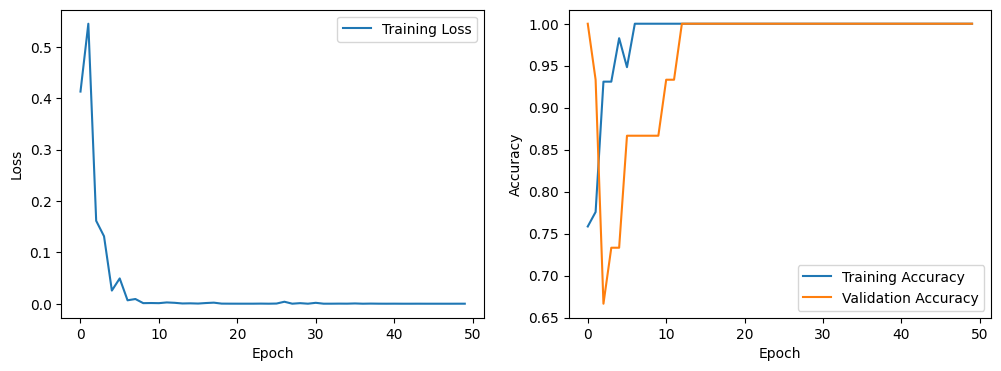

Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000
[[9 0]
 [0 6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100, Training Loss: 0.4986, Training Accuracy: 0.6724, Validation Accuracy: 0.5333
Epoch 2/100, Training Loss: 0.2602, Training Accuracy: 0.8966, Validation Accuracy: 0.7333
Epoch 3/100, Training Loss: 0.0790, Training Accuracy: 0.9828, Validation Accuracy: 0.7333
Epoch 4/100, Training Loss: 0.0638, Training Accuracy: 0.9828, Validation Accuracy: 0.6667
Epoch 5/100, Training Loss: 0.0120, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 6/100, Training Loss: 0.0065, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 7/100, Training Loss: 0.0046, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 8/100, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 9/100, Training Loss: 0.0007, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 10/100, Training Loss: 0.0026, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 11/100, Training Loss: 0.0015, Training Accuracy: 1.0000, Validation Accuracy: 0.86

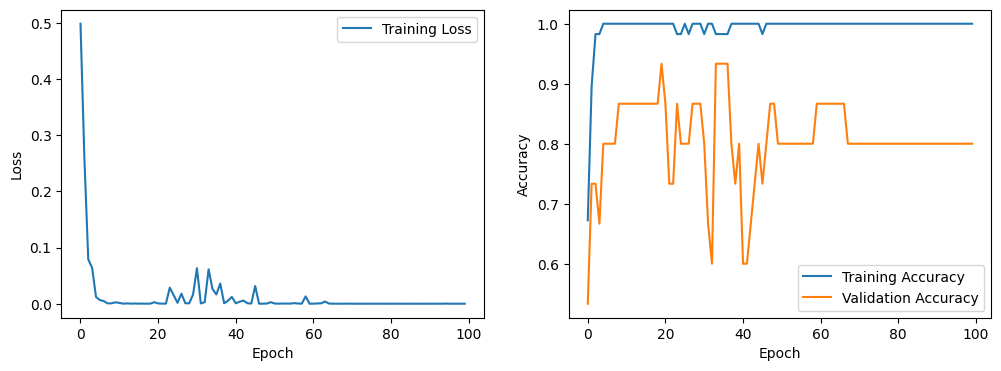

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8000
[[6 1]
 [2 6]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.86      0.75      0.80         8

    accuracy                           0.80        15
   macro avg       0.80      0.80      0.80        15
weighted avg       0.81      0.80      0.80        15



In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=100):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Training Loss: 0.4308, Training Accuracy: 0.7759, Validation Accuracy: 0.6667
Epoch 2/5, Training Loss: 0.2923, Training Accuracy: 0.8621, Validation Accuracy: 0.4667
Epoch 3/5, Training Loss: 0.1132, Training Accuracy: 0.9828, Validation Accuracy: 0.4667
Epoch 4/5, Training Loss: 0.0375, Training Accuracy: 0.9828, Validation Accuracy: 0.8000
Epoch 5/5, Training Loss: 0.1362, Training Accuracy: 0.9310, Validation Accuracy: 0.8667


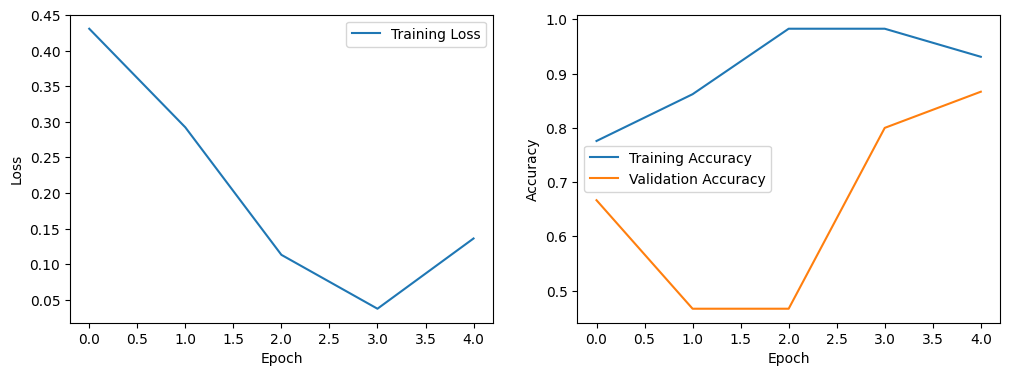

Final Training Accuracy: 0.9310
Final Validation Accuracy: 0.8667
[[7 0]
 [2 6]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.75      0.86         8

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15



In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=5):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Training Loss: 0.3490, Training Accuracy: 0.7931, Validation Accuracy: 0.6000
Epoch 2/5, Training Loss: 0.2367, Training Accuracy: 0.8966, Validation Accuracy: 0.9333
Epoch 3/5, Training Loss: 0.0807, Training Accuracy: 0.9828, Validation Accuracy: 0.8667
Epoch 4/5, Training Loss: 0.0017, Training Accuracy: 1.0000, Validation Accuracy: 0.8667
Epoch 5/5, Training Loss: 0.0130, Training Accuracy: 1.0000, Validation Accuracy: 0.8667


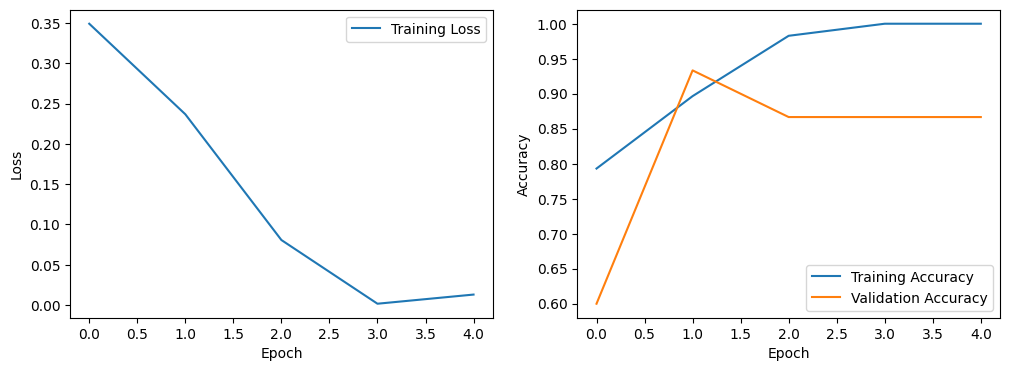

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8667
Sensitivity: 0.8333
Specificity: 0.8889
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.83      0.83      0.83         6

    accuracy                           0.87        15
   macro avg       0.86      0.86      0.86        15
weighted avg       0.87      0.87      0.87        15



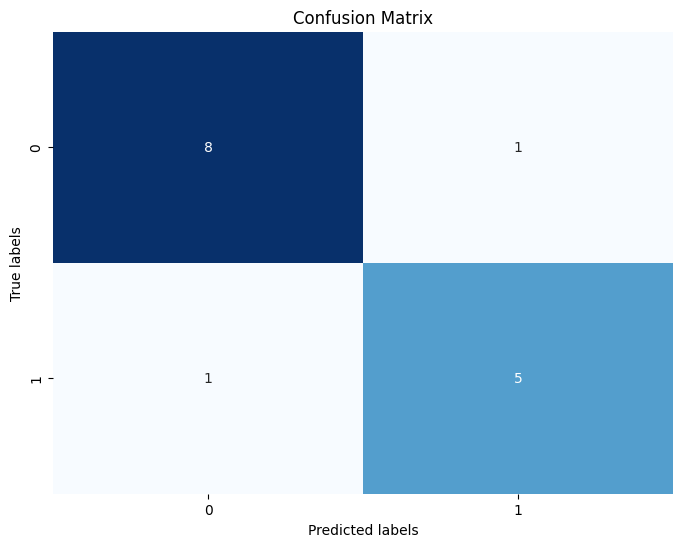

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=5):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

     # Calculate and print sensitivity and specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')


    # Print confusion matrix and classification report
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

   
# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Training Loss: 0.4955, Training Accuracy: 0.6552, Validation Accuracy: 0.9333
Epoch 2/5, Training Loss: 0.3851, Training Accuracy: 0.8448, Validation Accuracy: 0.6667
Epoch 3/5, Training Loss: 0.0447, Training Accuracy: 0.9828, Validation Accuracy: 0.6000
Epoch 4/5, Training Loss: 0.1245, Training Accuracy: 0.9655, Validation Accuracy: 0.8000
Epoch 5/5, Training Loss: 0.1313, Training Accuracy: 0.9483, Validation Accuracy: 0.8667


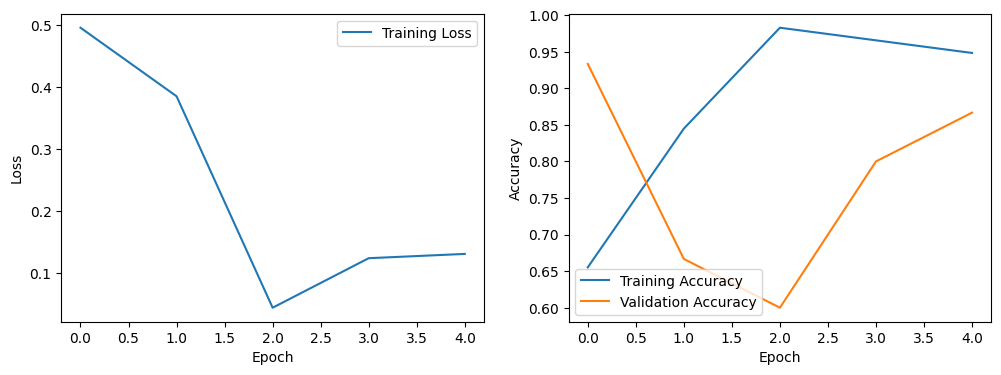

Final Training Accuracy: 0.9483
Final Validation Accuracy: 0.8667
Sensitivity: 0.4667
Specificity: 0.9778
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        45
           1       0.93      0.47      0.62        30

    accuracy                           0.77        75
   macro avg       0.83      0.72      0.73        75
weighted avg       0.81      0.77      0.75        75



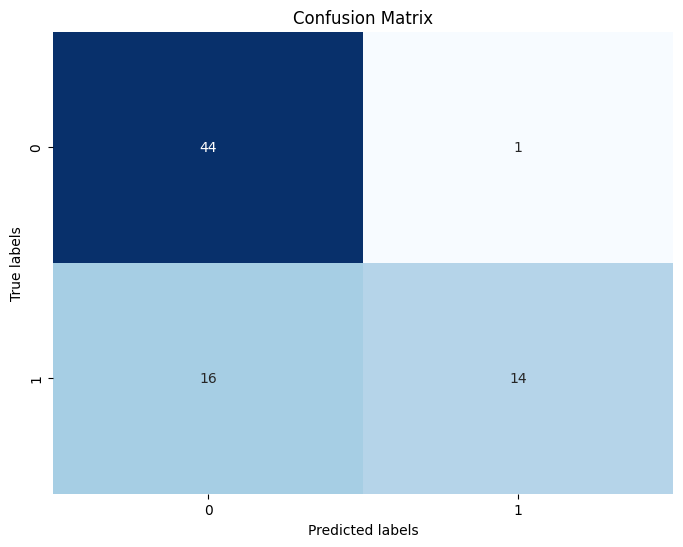

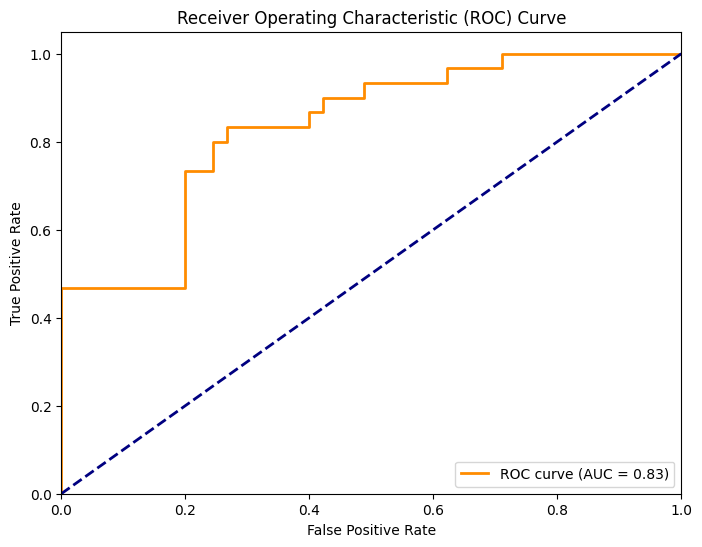

In [7]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=5):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    y_true = []
    y_pred_probs = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                # Store true labels and predicted probabilities for ROC curve
                y_true.extend(labels.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1).tolist())  # Extend instead of appending

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Calculate and print sensitivity and specificity
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Print confusion matrix and classification report
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)


# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Sakar dataset with 755 data points
batch size 32
50 epoch


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Training Loss: 0.5451, Training Accuracy: 0.7351, Validation Accuracy: 0.2171
Epoch 2/50, Training Loss: 0.3690, Training Accuracy: 0.8195, Validation Accuracy: 0.7829
Epoch 3/50, Training Loss: 0.3275, Training Accuracy: 0.8609, Validation Accuracy: 0.8026
Epoch 4/50, Training Loss: 0.2729, Training Accuracy: 0.8675, Validation Accuracy: 0.7500
Epoch 5/50, Training Loss: 0.2398, Training Accuracy: 0.8940, Validation Accuracy: 0.7368
Epoch 6/50, Training Loss: 0.1789, Training Accuracy: 0.9305, Validation Accuracy: 0.7829
Epoch 7/50, Training Loss: 0.1844, Training Accuracy: 0.9238, Validation Accuracy: 0.7303
Epoch 8/50, Training Loss: 0.1137, Training Accuracy: 0.9520, Validation Accuracy: 0.8487
Epoch 9/50, Training Loss: 0.1729, Training Accuracy: 0.9272, Validation Accuracy: 0.8816
Epoch 10/50, Training Loss: 0.1775, Training Accuracy: 0.9272, Validation Accuracy: 0.7763
Epoch 11/50, Training Loss: 0.1362, Training Accuracy: 0.9321, Validation Accuracy: 0.8289
Epoch 12

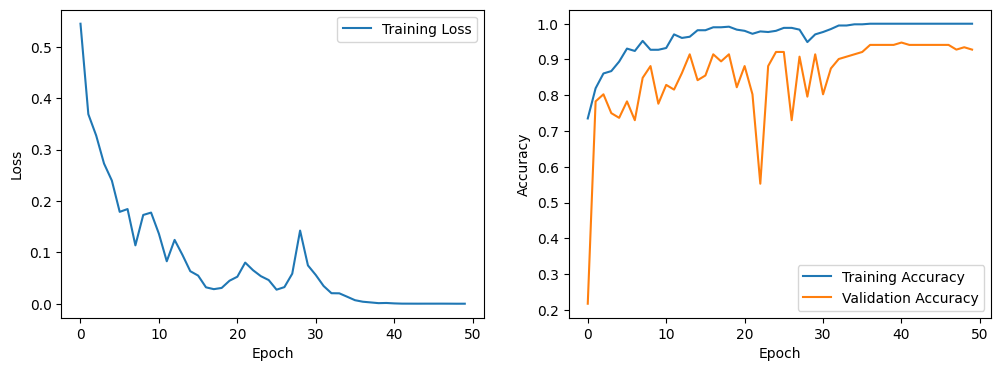

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9276
Sensitivity: 0.8855
Specificity: 0.7448
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      1650
           1       0.93      0.89      0.91      5950

    accuracy                           0.85      7600
   macro avg       0.78      0.82      0.80      7600
weighted avg       0.86      0.85      0.86      7600



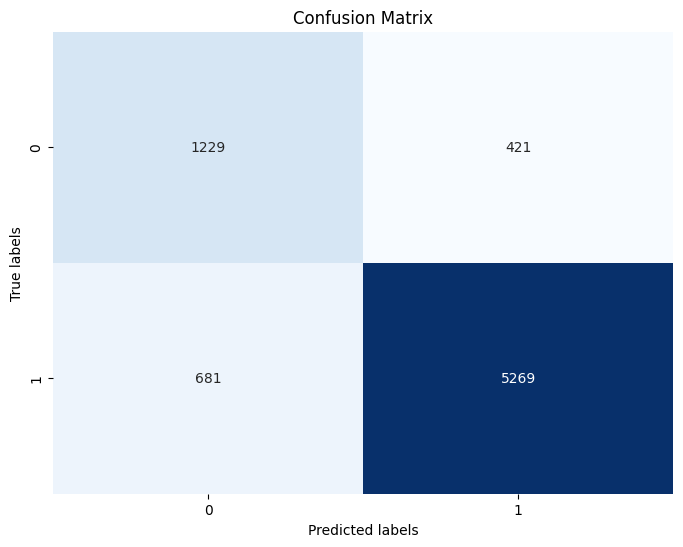

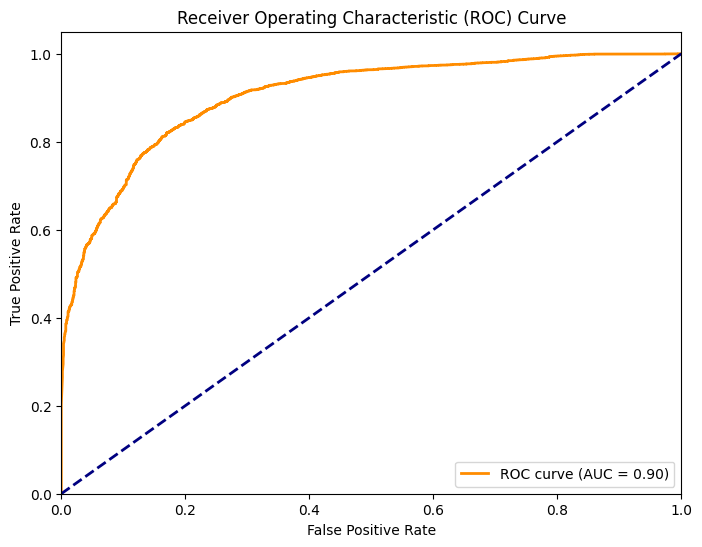

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    y_true = []
    y_pred_probs = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                # Store true labels and predicted probabilities for ROC curve
                y_true.extend(labels.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1).tolist())  # Extend instead of appending

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Calculate and print sensitivity and specificity
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Print confusion matrix and classification report
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)


# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Sakar pd speech time series converted\Normalised\spectrogram"
train_and_evaluate(data_path)


Number of samples in training set: 604
Number of samples in validation set: 152


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True labels: [1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Epoch 1/10, Training Loss: 0.9289, Validation Loss: 2.8

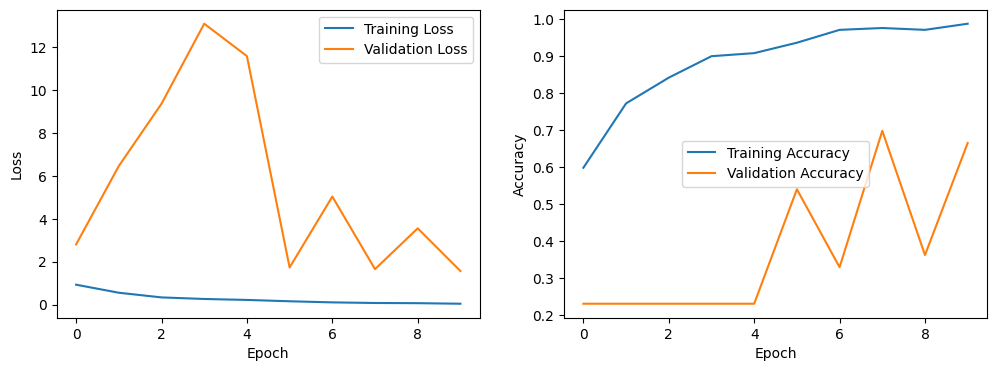

Final Training Accuracy: 0.9868
Final Validation Accuracy: 0.6645
Sensitivity: 0.5726
Specificity: 0.9714
              precision    recall  f1-score   support

           0       0.40      0.97      0.57        35
           1       0.99      0.57      0.72       117

    accuracy                           0.66       152
   macro avg       0.70      0.77      0.65       152
weighted avg       0.85      0.66      0.69       152



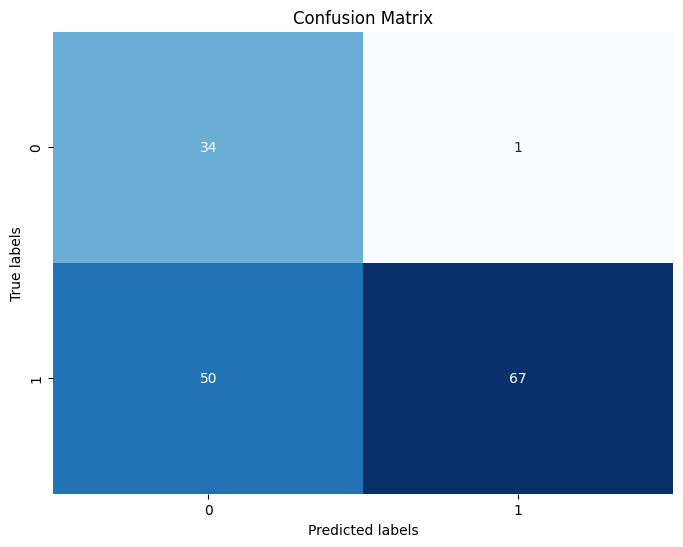

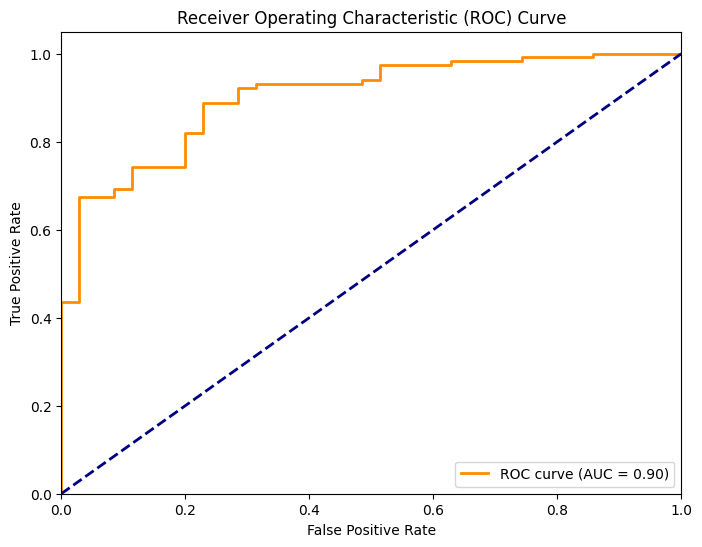

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=10):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Print number of datasets in training and validation sets
    print(f"Number of samples in training set: {len(train_dataset)}")
    print(f"Number of samples in validation set: {len(val_dataset)}")

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Clear lists at the beginning of each epoch
        y_true = []
        y_pred_probs = []

        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                # Store true labels and predicted probabilities for ROC curve
                y_true.extend(labels.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1).tolist())  # Extend instead of appending

            # Print true and predicted labels for the first batch of validation data
            print("True labels:", labels.tolist())
            print("Predicted labels:", predicted.tolist())

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Validation Loss: {average_val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Calculate and print sensitivity and specificity
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Print confusion matrix and classification report
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)


# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Sakar pd speech time series converted\Normalised\spectrogram"
train_and_evaluate(data_path)


learning rate =0.00001
batch size 16

Number of samples in training set: 604
Number of samples in validation set: 152


Epoch 1/50, Training Loss: 0.5173, Validation Loss: 3.1534, Training Accuracy: 0.7781, Validation Accuracy: 0.2368


Epoch 2/50, Training Loss: 0.3860, Validation Loss: 3.7162, Training Accuracy: 0.8212, Validation Accuracy: 0.2368


Epoch 3/50, Training Loss: 0.2640, Validation Loss: 0.8744, Training Accuracy: 0.8907, Validation Accuracy: 0.7697


Epoch 4/50, Training Loss: 0.2679, Validation Loss: 0.3809, Training Accuracy: 0.8957, Validation Accuracy: 0.8289


Epoch 5/50, Training Loss: 0.2271, Validation Loss: 1.9694, Training Accuracy: 0.9007, Validation Accuracy: 0.7632


Epoch 6/50, Training Loss: 0.1937, Validation Loss: 3.6128, Training Accuracy: 0.9123, Validation Accuracy: 0.7632


Epoch 7/50, Training Loss: 0.2089, Validation Loss: 0.8411, Training Accuracy: 0.8990, Validation Accuracy: 0.7500


Epoch 8/50, Training Loss: 0.2058, Validation Loss: 0.3848, Training Accuracy: 0.9156, Validation Accuracy: 0.8750


Epoch 9/50, Training Loss: 0.1536, Validation Loss: 0.5776, Training Accuracy: 0.9387, Validation Accuracy: 0.7566


Epoch 10/50, Training Loss: 0.1168, Validation Loss: 0.4680, Training Accuracy: 0.9536, Validation Accuracy: 0.8092


Epoch 11/50, Training Loss: 0.0840, Validation Loss: 2.6620, Training Accuracy: 0.9669, Validation Accuracy: 0.7632


Epoch 12/50, Training Loss: 0.0825, Validation Loss: 0.5502, Training Accuracy: 0.9669, Validation Accuracy: 0.8289


Epoch 13/50, Training Loss: 0.0515, Validation Loss: 0.2943, Training Accuracy: 0.9818, Validation Accuracy: 0.9013


Epoch 14/50, Training Loss: 0.0681, Validation Loss: 0.2680, Training Accuracy: 0.9752, Validation Accuracy: 0.8947


Epoch 15/50, Training Loss: 0.0790, Validation Loss: 0.3107, Training Accuracy: 0.9619, Validation Accuracy: 0.9211


Epoch 16/50, Training Loss: 0.1116, Validation Loss: 0.5119, Training Accuracy: 0.9437, Validation Accuracy: 0.8553


Epoch 17/50, Training Loss: 0.1034, Validation Loss: 0.5299, Training Accuracy: 0.9520, Validation Accuracy: 0.8947


Epoch 18/50, Training Loss: 0.0886, Validation Loss: 0.2521, Training Accuracy: 0.9586, Validation Accuracy: 0.9013


Epoch 19/50, Training Loss: 0.0722, Validation Loss: 0.3660, Training Accuracy: 0.9702, Validation Accuracy: 0.8947


Epoch 20/50, Training Loss: 0.0601, Validation Loss: 0.5084, Training Accuracy: 0.9752, Validation Accuracy: 0.8026


Epoch 21/50, Training Loss: 0.0562, Validation Loss: 0.2698, Training Accuracy: 0.9801, Validation Accuracy: 0.9079


Epoch 22/50, Training Loss: 0.0281, Validation Loss: 0.2603, Training Accuracy: 0.9901, Validation Accuracy: 0.9145


Epoch 23/50, Training Loss: 0.0113, Validation Loss: 0.2649, Training Accuracy: 0.9967, Validation Accuracy: 0.9211


Epoch 24/50, Training Loss: 0.0276, Validation Loss: 0.7569, Training Accuracy: 0.9901, Validation Accuracy: 0.8882


Epoch 25/50, Training Loss: 0.1310, Validation Loss: 0.7093, Training Accuracy: 0.9536, Validation Accuracy: 0.8421


Epoch 26/50, Training Loss: 0.0560, Validation Loss: 0.3207, Training Accuracy: 0.9735, Validation Accuracy: 0.8816


Epoch 27/50, Training Loss: 0.0401, Validation Loss: 0.2713, Training Accuracy: 0.9868, Validation Accuracy: 0.9211


Epoch 28/50, Training Loss: 0.0087, Validation Loss: 0.3222, Training Accuracy: 1.0000, Validation Accuracy: 0.8882


Epoch 29/50, Training Loss: 0.0131, Validation Loss: 0.3745, Training Accuracy: 0.9950, Validation Accuracy: 0.9013


Epoch 30/50, Training Loss: 0.0297, Validation Loss: 0.4746, Training Accuracy: 0.9868, Validation Accuracy: 0.8618


Epoch 31/50, Training Loss: 0.0570, Validation Loss: 0.4889, Training Accuracy: 0.9801, Validation Accuracy: 0.8618


Epoch 32/50, Training Loss: 0.0453, Validation Loss: 0.3279, Training Accuracy: 0.9851, Validation Accuracy: 0.9145


Epoch 33/50, Training Loss: 0.0132, Validation Loss: 0.2515, Training Accuracy: 0.9950, Validation Accuracy: 0.9342


Epoch 34/50, Training Loss: 0.0130, Validation Loss: 0.2037, Training Accuracy: 0.9950, Validation Accuracy: 0.8947


Epoch 35/50, Training Loss: 0.0112, Validation Loss: 0.3142, Training Accuracy: 0.9967, Validation Accuracy: 0.9211


Epoch 36/50, Training Loss: 0.0125, Validation Loss: 0.3260, Training Accuracy: 0.9967, Validation Accuracy: 0.9145


Epoch 37/50, Training Loss: 0.0187, Validation Loss: 0.2418, Training Accuracy: 0.9934, Validation Accuracy: 0.9342


Epoch 38/50, Training Loss: 0.0118, Validation Loss: 0.3034, Training Accuracy: 0.9950, Validation Accuracy: 0.9408


Epoch 39/50, Training Loss: 0.0128, Validation Loss: 0.3481, Training Accuracy: 0.9950, Validation Accuracy: 0.9276


Epoch 40/50, Training Loss: 0.0261, Validation Loss: 0.4579, Training Accuracy: 0.9901, Validation Accuracy: 0.8618


Epoch 41/50, Training Loss: 0.0340, Validation Loss: 0.6829, Training Accuracy: 0.9868, Validation Accuracy: 0.8487


Epoch 42/50, Training Loss: 0.0163, Validation Loss: 0.6802, Training Accuracy: 0.9950, Validation Accuracy: 0.8487


Epoch 43/50, Training Loss: 0.0282, Validation Loss: 0.5557, Training Accuracy: 0.9884, Validation Accuracy: 0.8487


Epoch 44/50, Training Loss: 0.0259, Validation Loss: 0.9535, Training Accuracy: 0.9917, Validation Accuracy: 0.7566


Epoch 45/50, Training Loss: 0.0645, Validation Loss: 1.5457, Training Accuracy: 0.9801, Validation Accuracy: 0.7895


Epoch 46/50, Training Loss: 0.0887, Validation Loss: 0.4233, Training Accuracy: 0.9619, Validation Accuracy: 0.8487


Epoch 47/50, Training Loss: 0.0380, Validation Loss: 0.3801, Training Accuracy: 0.9834, Validation Accuracy: 0.8947


Epoch 48/50, Training Loss: 0.0157, Validation Loss: 0.3380, Training Accuracy: 0.9967, Validation Accuracy: 0.9145


Epoch 49/50, Training Loss: 0.0129, Validation Loss: 0.6364, Training Accuracy: 0.9967, Validation Accuracy: 0.8289


Epoch 50/50, Training Loss: 0.0250, Validation Loss: 4.7088, Training Accuracy: 0.9934, Validation Accuracy: 0.7632


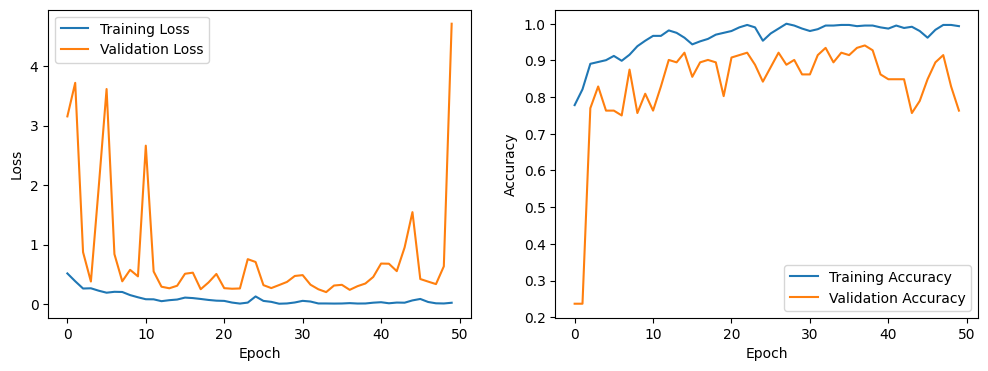

Final Training Accuracy: 0.9934
Final Validation Accuracy: 0.7632
Sensitivity: 1.0000
Specificity: 0.0000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.76      1.00      0.87       116

    accuracy                           0.76       152
   macro avg       0.38      0.50      0.43       152
weighted avg       0.58      0.76      0.66       152



C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

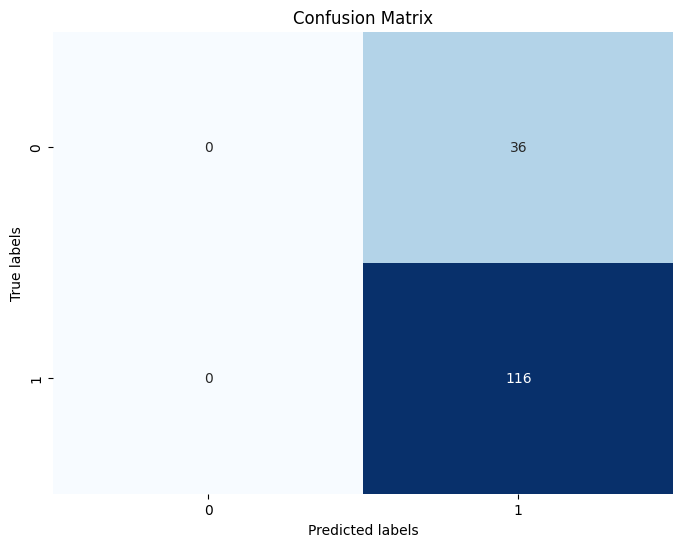

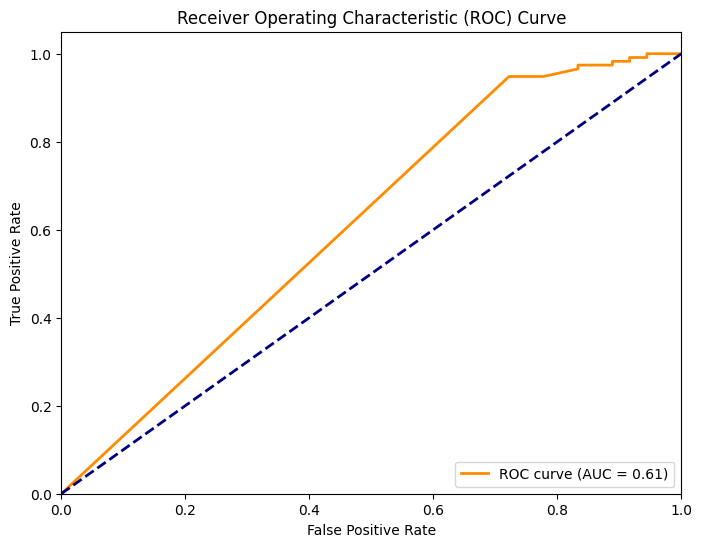

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 224, 224

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Print number of datasets in training and validation sets
    print(f"Number of samples in training set: {len(train_dataset)}")
    print(f"Number of samples in validation set: {len(val_dataset)}")

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained ResNet-18 model
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Change the output layer for binary classification
    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Clear lists at the beginning of each epoch
        y_true = []
        y_pred_probs = []

        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        # Wrap train_loader with tqdm for progress bar
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            train_loader.set_postfix({'Loss': loss.item(), 'Accuracy': (predicted == labels).sum().item() / labels.size(0)})

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        with torch.no_grad():
            # Wrap val_loader with tqdm for progress bar
            val_loader = tqdm(val_loader, desc='Validation', leave=False)
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                val_loader.set_postfix({'Loss': loss.item(), 'Accuracy': (predicted == labels).sum().item() / labels.size(0)})

                # Store true labels and predicted probabilities for ROC curve
                y_true.extend(labels.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1).tolist())  # Extend instead of appending

        average_val_loss = val_running_loss / len(val_loader)
        val_losses.append(average_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Validation Loss: {average_val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Calculate and print sensitivity and specificity
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Print confusion matrix and classification report
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)


# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Sakar pd speech time series converted\Normalised\spectrogram"
train_and_evaluate(data_path)
